# Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Dataset

In [5]:
with open('../../config.json', 'rb') as file:
    config = json.load(file)
csop_cols_to_ignore = config['csop']['cols_to_ignore']
csopII_cols_to_ignore = config['csopII']['cols_to_ignore']
csop_target, csopII_target = 'zscore_efficiency', 'efficiency'

In [6]:
csop_raw = pd.read_csv('../../output/csop_output_conversation_level.csv')
csop_all_features = csop_raw.drop(csop_cols_to_ignore, axis=1)
target_scaler = StandardScaler()
csop_all_features['target'] = target_scaler.fit_transform(csop_raw[csop_target].to_numpy().reshape(-1, 1))

csopII_raw = pd.read_csv('../../output/csopII_output_conversation_level.csv')
csopII_all_features = csopII_raw.drop(csopII_cols_to_ignore, axis=1)
csopII_all_features['target'] = target_scaler.transform(csopII_raw[csopII_target].to_numpy().reshape(-1, 1))

features = list(set(csop_all_features.columns).intersection(set(csopII_all_features.columns)))
csop, csopII = csop_all_features[features].copy(), csopII_all_features[features].copy()
csop, csopII = csop.fillna(0), csopII.fillna(0)

In [7]:
X, y = csop.drop(['target'], axis=1), csop['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_test, y_test = csopII.drop(['target'], axis=1), csopII['target']

feature_scaler = StandardScaler()
X_train = pd.DataFrame(feature_scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns)
X_val = pd.DataFrame(feature_scaler.transform(X_val.to_numpy()), columns=X_val.columns)
X_test = pd.DataFrame(feature_scaler.transform(X_test.to_numpy()), columns=X_test.columns)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((882, 386), (98, 386), (962, 386), (882,), (98,), (962,))

In [8]:
feature_groupings_raw = pd.read_excel('feature_groupings_06_20_23.xlsx')
groups = feature_groupings_raw.columns[2:]
groups

Index(['Communication Frequency', 'Information / Knowledge Exchange',
       'Linguistic Features', 'Emotion', 'Cognitive Processes',
       'Perceptual Processes', 'Social Processes', 'Biological Processes',
       'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
       'Hedging', 'Politeness', 'Equality'],
      dtype='object')

In [9]:
rows = []
for idx, row in tqdm(feature_groupings_raw.iterrows(), total=feature_groupings_raw.shape[0]):
    if row['Level'] == 'Chat':
        for prefix in ['min_', 'max_', 'stdev_', 'average_']:
            feature_name = prefix + row['Feature Name']
            row_to_append = [feature_name] + row[groups].to_list()
            rows.append(row_to_append)
    else:
        feature_name = row['Feature Name']
        row_to_append = [feature_name] + row[groups].to_list()
        rows.append(row_to_append)
feature_groupings = pd.DataFrame(
    rows, 
    columns= [
        'Feature Name', 'Communication Frequency', 'Information / Knowledge Exchange',
        'Linguistic Features', 'Emotion', 'Cognitive Processes',
        'Perceptual Processes', 'Social Processes', 'Biological Processes',
        'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
        'Hedging', 'Politeness', 'Equality'
    ]
)

100%|██████████| 99/99 [00:00<00:00, 1788.26it/s]


In [10]:
feature_groupings

,Feature Name,Communication Frequency,Information / Knowledge Exchange,Linguistic Features,Emotion,Cognitive Processes,Perceptual Processes,Social Processes,Biological Processes,Personal Concerns,Accommodation/\nMimicry,Temporal,Question,Hedging,Politeness,Equality
0,min_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,max_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,stdev_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,average_num_words,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,min_num_chars,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,max_indicative,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
386,stdev_indicative,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
387,average_indicative,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
388,gini_coefficient_num_words,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Creating Data Loaders

In [24]:
class CSOPDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [28]:
train_dataset = CSOPDataset(X=X_train.to_numpy(), y=y_train.to_numpy())
val_dataset = CSOPDataset(X=X_val.to_numpy(), y=y_val.to_numpy())

In [29]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

# Model Definition

In [39]:
class CSOPFullyConnectedNN(nn.Module):
    def __init__(self, num_input_features):
        super().__init__()
        self.net = nn.Linear(in_features=num_input_features, out_features=1)
        self.net.weight.data.normal_(mean=0, std=0.01)
        self.net.weight.data = self.net.weight.data.to(torch.float64)
        self.net.bias.data.fill_(value=0)
        self.net.bias.data = self.net.bias.data.to(torch.float64)

    def forward(self, X):
        return self.net(X)

In [40]:
fully_connected_nn = CSOPFullyConnectedNN(num_input_features=X_train.shape[1])

# Model Training

In [47]:
optimizer = Adam
loss_fn = nn.MSELoss()
max_epochs = 100
early_stopping_tol = 1000

In [45]:
class Trainer():
  def __init__(
    self, model, optimizer, loss_fn,
    train_dataloader, val_dataloader,
    max_epochs=50, tol=10
  ):
    self.model = model
    self.optimizer = optimizer(params=self.model.parameters(), lr=0.0003)
    self.loss_fn = loss_fn
    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader
    self.max_epochs = max_epochs
    self.train_losses = []
    self.val_losses = []
    self.best_val_loss = float('inf')
    self.best_val_loss_epoch = -1
    self.tol = tol
    self.max_tol = tol

  def fit(self):
    for epoch_idx in range(self.max_epochs):
      if self.tol == 0:
        print('Using Early Stopping')
        break
      self.train_one_epoch()
      self.early_stopping(epoch_idx=epoch_idx)
      print(f'Epoch {epoch_idx}\t Train Loss: {self.train_losses[-1]}\tVal Loss: {self.val_losses[-1]}')
    print(f'Best Model Found at Epoch {self.best_val_loss_epoch}')

  def train_one_epoch(self):
    training_loss = 0
    for features, labels in self.train_dataloader:
      self.optimizer.zero_grad()
      predictions = self.model(features)
      loss = self.loss_fn(predictions, labels)
      training_loss += loss.item()
      loss.backward()
      nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0, norm_type=2)
      self.optimizer.step()
    self.train_losses.append(training_loss/len(self.train_dataloader))

    val_loss = 0
    with torch.no_grad():
      for features, labels in self.val_dataloader:
        predictions = self.model(features)
        loss = self.loss_fn(predictions, labels)
        val_loss += loss.item()
      self.val_losses.append(val_loss/len(self.val_dataloader))

  def early_stopping(self, epoch_idx):
    current_val_loss = self.val_losses[-1]
    if current_val_loss < self.best_val_loss:
      self.best_val_loss = current_val_loss
      self.best_val_loss_epoch = epoch_idx
      model_path = f'feature_bagging_nn_models/best_model'
      torch.save(self.model.state_dict(), model_path)
      self.tol = self.max_tol
    else:
      self.tol -= 1

In [48]:
trainer = Trainer(
  model=fully_connected_nn, optimizer=optimizer, loss_fn=loss_fn,
  train_dataloader=train_dataloader, val_dataloader=val_dataloader,
  max_epochs=max_epochs, tol=early_stopping_tol
)

In [49]:
trainer.fit()

/Users/yashv/Desktop/UPenn_Courses/Labs/CSS/team-process-map/team_process_map/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yashv/Desktop/UPenn_Courses/Labs/CSS/team-process-map/team_process_map/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yashv/Desktop/UPenn_Courses/Labs/CSS/team-process-map/team_process_map/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Si

Epoch 0	 Train Loss: 1.019227436454427	Val Loss: 1.0359430862698962
Epoch 1	 Train Loss: 0.9998762963346252	Val Loss: 1.0211222338005064
Epoch 2	 Train Loss: 1.007605897508711	Val Loss: 1.262061252275625
Epoch 3	 Train Loss: 0.9873143993830981	Val Loss: 1.1356285001776296
Epoch 4	 Train Loss: 0.988879266264198	Val Loss: 1.2475254577154546
Epoch 5	 Train Loss: 0.992034229730142	Val Loss: 1.1004452479346463
Epoch 6	 Train Loss: 0.9894096606156614	Val Loss: 1.1706022428959075
Epoch 7	 Train Loss: 0.9896969192124235	Val Loss: 1.168367032921406
Epoch 8	 Train Loss: 0.9872228414687633	Val Loss: 1.0754712748551851
Epoch 9	 Train Loss: 0.9952016757161211	Val Loss: 1.093809532064851
Epoch 10	 Train Loss: 0.9948504250054022	Val Loss: 1.1791052335437318
Epoch 11	 Train Loss: 0.9840994587633196	Val Loss: 1.1536095468326204
Epoch 12	 Train Loss: 0.9874005713839255	Val Loss: 1.2339649238196115
Epoch 13	 Train Loss: 0.9837365463906698	Val Loss: 1.156821067261616
Epoch 14	 Train Loss: 0.98257883949293

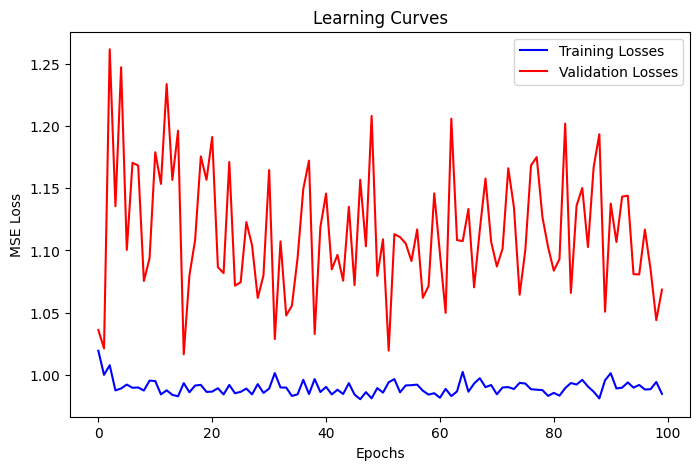

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(trainer.train_losses, color='blue', label='Training Losses')
ax.plot(trainer.val_losses, color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()

In [51]:
fully_connected_nn_trained = trainer.model